In [11]:
import pandas as pd
import geopandas as gpd
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
import requests
import re
from geopandas.tools import sjoin
import rtree
import plotnine as p9
from plotnine import *
import numpy as np

# get census tract shapes

In [2]:
main_url = 'https://www2.census.gov/geo/tiger/TIGER2014/TRACT/'

raw_content = requests.get(main_url).text
parsed_content = BeautifulSoup(raw_content, 'html.parser')

find_links = parsed_content.findAll("a", attrs = {"href": re.compile("tract")})
zip_names = [link.get('href') for link in find_links]
zip_links = [main_url + link for link in zip_names]

In [3]:
list_of_tract_shapes = [gpd.read_file(link) for link in zip_links]
tract_shapes = pd.concat(list_of_tract_shapes)
tract_shapes.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,01,089,001902,01089001902,19.02,Census Tract 19.02,G5020,S,12784312,8256,+34.6825950,-086.5407538,"POLYGON ((-86.55607 34.67424, -86.55598 34.674..."
1,01,089,010800,01089010800,108,Census Tract 108,G5020,S,62434260,418101,+34.7623828,-086.4951024,"POLYGON ((-86.55461 34.78647, -86.55461 34.786..."
2,01,089,010701,01089010701,107.01,Census Tract 107.01,G5020,S,88171204,277431,+34.8667659,-086.5784822,"POLYGON ((-86.64287 34.87641, -86.64282 34.876..."
3,01,089,011014,01089011014,110.14,Census Tract 110.14,G5020,S,10927369,11607,+34.7176388,-086.7667595,"POLYGON ((-86.78654 34.70279, -86.78653 34.703..."
4,01,089,010301,01089010301,103.01,Census Tract 103.01,G5020,S,87926545,152312,+34.9392227,-086.5836942,"POLYGON ((-86.64212 34.93313, -86.64210 34.934..."


# get intersections of h2a violations and tracts

In [4]:
h2a = pd.read_pickle("../../qss20_finalproj_rawdata/summerwork/intermediate/h2a_combined_2014-2021_geocoded.pkl")
print(h2a.columns)
h2a_geom = gpd.GeoDataFrame(h2a, geometry=gpd.points_from_xy(h2a.geo_long, h2a.geo_lat))
h2a_geom.head()

Index(['CASE_NUMBER', 'ATTORNEY_AGENT_CITY', 'JOB_TITLE', 'EMPLOYER_STATE',
       'SOC_CODE', 'data_source', 'REQUESTED_END_DATE_OF_NEED', 'SOC_TITLE',
       'EMPLOYER_CITY', 'JOB_END_DATE', 'CASE_STATUS', 'ATTORNEY_AGENT_STATE',
       'EMPLOYER_ADDRESS1', 'JOB_START_DATE', 'REQUESTED_START_DATE_OF_NEED',
       'EMPLOYER_POSTAL_CODE', 'EMPLOYER_NAME', 'WORKSITE_STATE',
       'ATTORNEY_AGENT_NAME', 'WORKSITE_CITY', 'DECISION_DATE',
       'EMPLOYER_FULLADDRESS', 'geo_lat', 'geo_long', 'geo_accuracy',
       'geo_accuracy_type'],
      dtype='object')


,CASE_NUMBER,ATTORNEY_AGENT_CITY,JOB_TITLE,EMPLOYER_STATE,SOC_CODE,data_source,REQUESTED_END_DATE_OF_NEED,SOC_TITLE,EMPLOYER_CITY,JOB_END_DATE,...,WORKSITE_STATE,ATTORNEY_AGENT_NAME,WORKSITE_CITY,DECISION_DATE,EMPLOYER_FULLADDRESS,geo_lat,geo_long,geo_accuracy,geo_accuracy_type,geometry
0,H-300-12345-457400,CRAIG,Livestock Worker,WY,45-2093,file_2014,2014-12-01 00:00:00,"Farmworkers, Farm, Ranch, and Aquacultural Ani...",Baggs,2014-12-01,...,WY,KANDANCE KROPINAK,Baggs,2014-03-03 10:30:27.000000,"PO Box 369, Baggs WY 82321",41.025579,-107.569976,0.33,place,POINT (-107.56998 41.02558)
1,H-300-12348-698598,CRAIG,Livestock Worker,WY,45-2093,file_2014,2014-12-15 00:00:00,"Farmworkers, Farm, Ranch, and Aquacultural Ani...",Baggs,2014-12-15,...,WY,KANDANCE KROPINAK,Baggs,2014-02-27 13:25:08.999996,"PO Box 6, Baggs WY 82321",41.025579,-107.569976,0.33,place,POINT (-107.56998 41.02558)
2,H-300-13007-934412,HEYBURN,Farm/Irrigation/Livestock Worker,ID,45-2092,file_2014,2014-11-15 00:00:00,"Farmworkers and Laborers, Crop, Nursery, and",Hammett,2014-11-15,...,ID,MICHAELENE ROWE,Hammett,2014-02-24 10:05:12.000002,"51854 State Hwy.78, Hammett ID 83627",42.945730,-115.466190,0.33,place,POINT (-115.46619 42.94573)
3,H-300-13009-524994,JOHNS ISLAND,Farmworker,GA,45-2092,file_2014,2014-06-20 00:00:00,"Farmworkers and Laborers, Crop, Nursery, and",Riceboro,2014-06-20,...,GA,MICHAEL LALICH,Riceboro,2014-03-28 12:47:28.999997,"3982 Jones Road NW, Riceboro GA 31323",31.631219,-81.478047,0.60,street_center,POINT (-81.47805 31.63122)
4,H-300-13050-453923,LEXINGTON,FARM WORKER FARM & RANCH ANIMALS,TX,45-2093,file_2014,2014-12-01 00:00:00,"Farmworkers, Farm, Ranch, and Aquacultural Ani...",MIDLAND,2014-12-01,...,TX,DONNA CARPENTER,MIDLAND,2014-01-24 09:12:22.000003,"600 NORTH BIG SPRING STREET, MIDLAND TX 79701",32.002923,-102.077871,1.00,rooftop,POINT (-102.07787 32.00292)


In [10]:
h2a_tract_joined = sjoin(h2a_geom.set_crs(tract_shapes.crs), tract_shapes, how = 'right', op = 'intersects')

h2a_tract_joined.to_pickle('../../qss20_finalproj_rawdata/summerwork/intermediate/h2a_tract_intersections.pkl')

# map visual

In [6]:
cases_by_tract = h2a_tract_joined.groupby('GEOID').CASE_NUMBER.agg('nunique').reset_index()
merged = gpd.GeoDataFrame(cases_by_tract.merge(h2a_tract_joined[['GEOID', 'STATEFP', 'geometry']], 
                          how = 'left', on = 'GEOID').drop_duplicates(), geometry = 'geometry')
merged.sort_values('CASE_NUMBER')

,GEOID,CASE_NUMBER,STATEFP,geometry
0,01001020100,0,01,"POLYGON ((-86.51038 32.47225, -86.51031 32.472..."
104858,36119013201,0,36,"POLYGON ((-73.88718 41.13309, -73.88740 41.136..."
104859,36119013202,0,36,"POLYGON ((-73.85608 41.15486, -73.85278 41.159..."
104860,36119013301,0,36,"POLYGON ((-73.89968 41.15729, -73.87066 41.161..."
104861,36119013304,0,36,"POLYGON ((-73.89248 41.15059, -73.87115 41.153..."
...,...,...,...,...
55626,21035010700,389,21,"POLYGON ((-88.48910 36.50491, -88.48909 36.505..."
139306,47147080200,516,47,"POLYGON ((-87.15037 36.56682, -87.15023 36.567..."
112199,37125950502,842,37,"POLYGON ((-79.41569 35.26277, -79.41510 35.262..."
50156,19083480400,952,19,"POLYGON ((-93.49958 42.54407, -93.49956 42.544..."


In [7]:
plot = merged
plot['CASE_NUMBER'] = plot['CASE_NUMBER'].replace(0, np.nan)

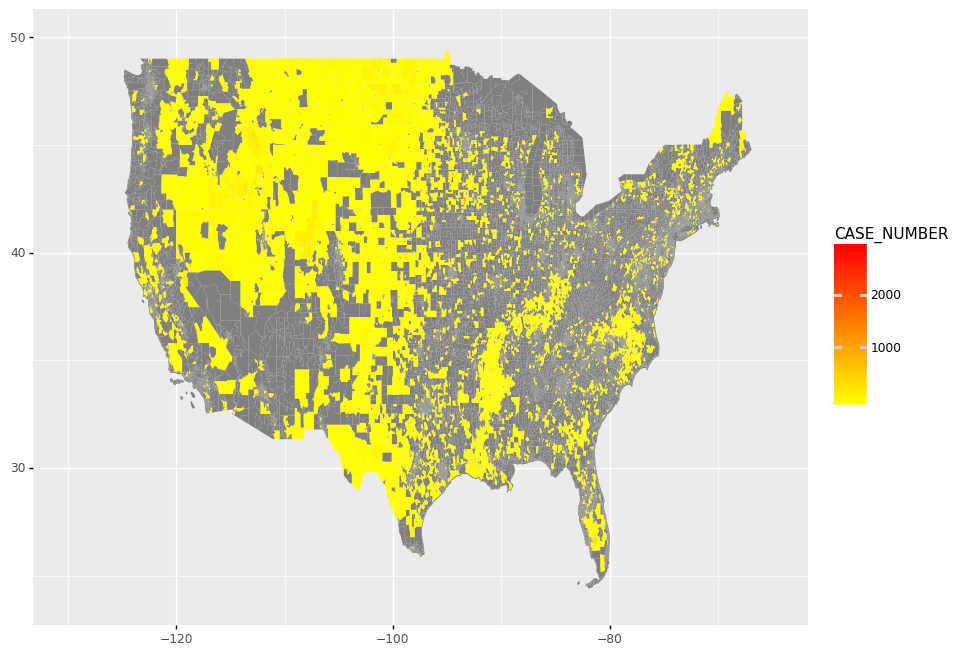

<ggplot: (305234899)>

In [8]:
p9.options.figure_size = (10, 8)

ggplot(plot) + \
    geom_map(aes(fill = 'CASE_NUMBER'), size = 0) + \
    scale_fill_gradient(low='yellow',high='red', na_value = 'grey') + \
    xlim(-130, -65) + \
    ylim(24, 50)

In [9]:
h2a_tract_joined[h2a_tract_joined.GEOID == '16083001100']

,index_left,CASE_NUMBER,ATTORNEY_AGENT_CITY,JOB_TITLE,EMPLOYER_STATE,SOC_CODE,data_source,REQUESTED_END_DATE_OF_NEED,SOC_TITLE,EMPLOYER_CITY,...,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
261,328.0,H-300-15281-724016,NaN,SHEEPHERDER,ID,45-2093,file_2016,2016-12-09 00:00:00,"Farmworkers, Farm, Ranch, and Aquacultural Ani...",TWIN FALLS,...,16083001100,11,Census Tract 11,G5020,S,2214343,0,+42.5568530,-114.4693499,"POLYGON ((-114.48016 42.55473, -114.48013 42.5..."
261,796.0,H-300-15315-939576,NaN,Sheepherder,ID,45-2093,file_2016,2017-01-09 00:00:00,"Farmworkers, Farm, Ranch, and Aquacultural Ani...",TWIN FALLS,...,16083001100,11,Census Tract 11,G5020,S,2214343,0,+42.5568530,-114.4693499,"POLYGON ((-114.48016 42.55473, -114.48013 42.5..."
261,1148.0,H-300-15329-757634,NaN,Sheepherder,ID,45-2093,file_2016,2017-01-07 00:00:00,"Farmworkers, Farm, Ranch, and Aquacultural Ani...",TWIN FALLS,...,16083001100,11,Census Tract 11,G5020,S,2214343,0,+42.5568530,-114.4693499,"POLYGON ((-114.48016 42.55473, -114.48013 42.5..."
261,1514.0,H-300-15345-568879,NaN,SHEEPHERDER,ID,45-2093,file_2016,2017-02-07 00:00:00,"Farmworkers, Farm, Ranch, and Aquacultural Ani...",TWIN FALLS,...,16083001100,11,Census Tract 11,G5020,S,2214343,0,+42.5568530,-114.4693499,"POLYGON ((-114.48016 42.55473, -114.48013 42.5..."
261,3026.0,H-300-16014-170843,NaN,Sheepherder,ID,45-2093,file_2016,2017-03-08 00:00:00,"Farmworkers, Farm, Ranch, and Aquacultural Ani...",TWIN FALLS,...,16083001100,11,Census Tract 11,G5020,S,2214343,0,+42.5568530,-114.4693499,"POLYGON ((-114.48016 42.55473, -114.48013 42.5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,10092.0,H-300-20287-876832,NaN,RANGE WINTER SHEEPHERDER,ID,45-2093.00,file_2021,2021-03-31 00:00:00,"Farmworkers, Farm, Ranch, and Aquacultural Ani...",TWIN FALLS,...,16083001100,11,Census Tract 11,G5020,S,2214343,0,+42.5568530,-114.4693499,"POLYGON ((-114.48016 42.55473, -114.48013 42.5..."
261,10129.0,H-300-20317-910084,NaN,RANGE SHEEPHERDER,ID,45-2093.00,file_2021,2021-10-01 00:00:00,"Farmworkers, Farm, Ranch, and Aquacultural Ani...",TWIN FALLS,...,16083001100,11,Census Tract 11,G5020,S,2214343,0,+42.5568530,-114.4693499,"POLYGON ((-114.48016 42.55473, -114.48013 42.5..."
261,10133.0,H-300-20318-911634,NaN,RANGE WINTER SHEEPHERDER,ID,45-2093.00,file_2021,2021-05-31 00:00:00,"Farmworkers, Farm, Ranch, and Aquacultural Ani...",TWIN FALLS,...,16083001100,11,Census Tract 11,G5020,S,2214343,0,+42.5568530,-114.4693499,"POLYGON ((-114.48016 42.55473, -114.48013 42.5..."
261,10184.0,H-300-21012-007690,NaN,RANGE SHEEPHERDER,ID,45-2093.00,file_2021,2021-10-31 00:00:00,"Farmworkers, Farm, Ranch, and Aquacultural Ani...",TWIN FALLS,...,16083001100,11,Census Tract 11,G5020,S,2214343,0,+42.5568530,-114.4693499,"POLYGON ((-114.48016 42.55473, -114.48013 42.5..."
